<a href="https://colab.research.google.com/github/antocommi/provagcp/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required modules 
----

In [ ]:
# # DOPO AVER ESEGUITO QUESTA CELLA RIAVVIARE IL RUNTIME!

!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

!git clone https://github.com/facebookresearch/slowfast

%cd slowfast
!python setup.py build develop

!export PYTHONPATH=/path/to/SlowFast/slowfast:$PYTHONPATH

# # DOPO AVER ESEGUITO QUESTA CELLA RIAVVIARE IL RUNTIME!

In [ ]:
from slowfast.config.defaults import get_cfg
from slowfast.models import build_model
from slowfast.utils.checkpoint import load_checkpoint
import wget

Dependencies
-----

In [1]:
!pip install -q -U albumentations

     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 37.6MB 84kB/s 
     |████████████████████████████████| 952kB 50.1MB/s 


In [1]:
SEED = 9126

 

import os, cv2, json, time, math, sys, pickle, collections, PIL
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A


from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)
import seaborn as sn

#from vmz import models
#import mmaction

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
if CUDA:
    print('run on %s' % device)

Mounted at /content/drive
run on cuda



Importing from Kaggle
====

In [2]:
# Download and load in memory dataset from kaggle
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"antocommii","key":"87dcebd7c4cb4ba4539ed72f027fcbde"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!kaggle datasets download --unzip --force antocommii/spacejam-action-recognition -p /content/kaggle/

# abbiamo 10 classi
num_classes = 10

# il dataset è ciò che si ottiene dal metodo precedente
ROOT_DIR = "/content/kaggle/"
VIDEO_DIR = "/content/kaggle/examples/"
ANNOTATION_FILE = "annotation_dict.json"
TEST_SET_FILE = "testset_keys_1lug2020.txt"

# prendo il dataset da annotation file
with open(os.path.join(ROOT_DIR, ANNOTATION_FILE)) as fp:
  annotations = json.load(fp)
            
with open(os.path.join(ROOT_DIR, TEST_SET_FILE)) as fp:
  keys_test = json.load(fp)

# divido in train e test second quello che ho nel file
annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))
test_set = list(annotationTest.items())

# divido in train e validation
test_size = 0.2
train_set, valid_set = train_test_split(list(annotationTrain.items()), random_state=456, test_size=test_size, stratify=list(annotationTrain.values()))

 98% 612M/626M [00:05<00:00, 110MB/s]
100% 626M/626M [00:05<00:00, 118MB/s]


Scelgo nuova size e definisco la struttura del Custom Dataset
====

In [3]:
class CustomSet(torch.utils.data.Dataset):
    def __init__(self, videos_dir, list_dataset, transform):
        """ Construct an indexed list of video paths and labels """
        self.transform = transform
        self.VIDEO_DIR = videos_dir
        self.dataset = list_dataset
        mean = [0.485,0.456,0.406]
        std = [0.229,0.224,0.225]
        self.toTensor = transforms.Compose([
                                            transforms.ToTensor(),
                                            #transforms.Normalize(mean, std)
        ])

    def __getitem__(self, index, is_for_testing=True):
        """ Load video n in the list of image paths and return it along with its label.
            In the case of multiclass the label will probably be a list of values"""
        
        name, label = self.dataset[index]
        
        fname = os.path.join(self.VIDEO_DIR, name+'.mp4')
        
        video = []
        vid = cv2.VideoCapture(fname)
        first = True
        while True:
            # Capture frame-by-frame
            ret, frame = vid.read()
            if ret != True:
              break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if first:
              data = self.transform(image=np.array(frame))
              frame = data['image']
              replay = data['replay']
              first = False
            else: 
              frame = A.ReplayCompose.replay(replay, image=np.array(frame))['image']

            frame = self.toTensor(Image.fromarray(frame))
            video.append(frame)

        video = torch.stack(video)
        video = torch.transpose(video, 1, 0)
        return {'video':video, 'label':torch.LongTensor([label])}
        

    def __len__(self):
        """ return the total number of video in this dataset """
        return len(self.dataset)

    def get_list(self):
      return self.dataset

Creazione Train, Validation e Test set
====

In [8]:
crop_H, crop_W = 176,70
new_H, new_W = 224,224
print("New Size: ",new_H,new_W)
print("Crop Size: ",crop_H, crop_W)

A_train = A.ReplayCompose([
                     A.augmentations.transforms.CenterCrop(crop_H, crop_W, p=1),
                    #  A.HorizontalFlip(p=0.5),
                     A.augmentations.Resize(crop_H, crop_H, p=1),
                     A.HorizontalFlip(p=0.5),
                     A.ShiftScaleRotate(scale_limit=(0,.4), rotate_limit=0.2,p=0.6),
                     A.augmentations.transforms.CLAHE(clip_limit=4.0, p=1)
                     #A.augmentations.transforms.FancyPCA(alpha=.5, p=1)
                     ])

A_test = A.ReplayCompose([
                     A.augmentations.transforms.CenterCrop(crop_H, crop_W, p=1),
                     A.augmentations.Resize(crop_H, crop_H, p=1)
                     ])


# trasformo in custom_dataset
train_ds = CustomSet(VIDEO_DIR, train_set, A_train)
valid_ds = CustomSet(VIDEO_DIR, valid_set, A_test)
test_ds = CustomSet(VIDEO_DIR, test_set, A_test)

# definisco le batch_size
BATCH_TRAIN_SIZE, BATCH_TEST_SIZE = 16,16

# creo i dataloader
trainLoader = DataLoader(train_ds, batch_size=BATCH_TRAIN_SIZE, shuffle=True,num_workers=4)
validLoader = DataLoader(valid_ds, batch_size=BATCH_TEST_SIZE, shuffle=True,num_workers=4)
testLoader = DataLoader(test_ds, batch_size=BATCH_TEST_SIZE, shuffle=True,num_workers=4)

# controllo se hanno la stessa forma di lista di tuple
print(len(trainLoader), len(validLoader), len(testLoader))
print(train_set[0])

New Size:  224 224
Crop Size:  176 70
1298 325 696
('0011804', 9)


walk


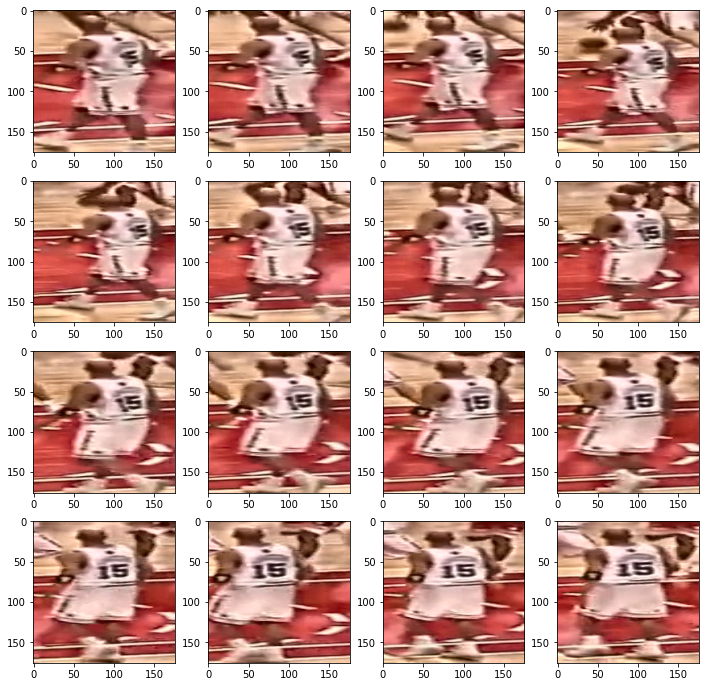

In [ ]:
labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

for item in trainLoader:
  video = item['video'][0]
  label = item['label'][0]
  break
clip = torch.transpose(video, 0, 1)

print(labels_dict[label.item()])
plt.figure(figsize=(12, 12))
for i in range(clip.shape[0]):
  plt.subplot(4,4, i+1)
  video = clip[i]
  trans = transforms.ToPILImage(mode="RGB")
  video = trans(video)
  plt.imshow(video)
plt.show()

Build modello
====

Rete SlowFast - pre-trained
--- 
https://github.com/facebookresearch/SlowFast/blob/master/MODEL_ZOO.md

In [ ]:
cfg = get_cfg()
cfg.merge_from_file('./slowfast/configs/Kinetics/c2/SLOWFAST_4x16_R50.yaml')
url = 'https://dl.fbaipublicfiles.com/pyslowfast/model_zoo/kinetics400/SLOWFAST_4x16_R50.pkl'

filename = wget.download(url)
cfg.TRAIN.CHECKPOINT_FILE_PATH = url
cfg.TRAIN.CHECKPOINT_FILE_PATH = filename + 'skdosjd'
cfg.TRAIN.CHECKPOINT_EPOCH_RESET = True
cfg.NUM_GPUS = 1
cfg.TRAIN.BATCH_SIZE = BATCH_TRAIN_SIZE
cfg.DATA.NUM_FRAMES = 16
model = build_model(cfg)
r = load_checkpoint(filename,model,data_parallel=False,convert_from_caffe2=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.projection.in_features
print(n_inputs)
model.head.projection = nn.Linear(n_inputs, 10)

Rete SlowFast
----

https://github.com/r1ch88/SlowFastNetworks/blob/master/lib/slowfastnet.py

In [5]:
_all__ = ['resnet50', 'resnet101','resnet152', 'resnet200']



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=(1, 3, 3), stride=(1,stride,stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class SlowFast(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], class_num=10, dropout=0.5 ):
        super(SlowFast, self).__init__()

        self.fast_inplanes = 8
        self.fast_conv1 = nn.Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ReLU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res2 = self._make_layer_fast(block, 8, layers[0], head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 16, layers[1], stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 32, layers[2], stride=2, head_conv=3)
        self.fast_res5 = self._make_layer_fast(
            block, 64, layers[3], stride=2, head_conv=3)
        
        self.lateral_p1 = nn.Conv3d(8, 8*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res2 = nn.Conv3d(32,32*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res3 = nn.Conv3d(64,64*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res4 = nn.Conv3d(128,128*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))

        self.slow_inplanes = 64+64//8*2
        self.slow_conv1 = nn.Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ReLU(inplace=True)
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res2 = self._make_layer_slow(block, 64, layers[0], head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 128, layers[1], stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 256, layers[2], stride=2, head_conv=3)
        self.slow_res5 = self._make_layer_slow(
            block, 512, layers[3], stride=2, head_conv=3)
        
        self.dp = nn.Dropout(dropout)
        self.fc = nn.Linear(self.fast_inplanes+2048, class_num, bias=False)
    
    def forward(self, input ):
        fast, lateral = self.FastPath(input[:, :, ::1, :, :])
        slow = self.SlowPath(input[:, :, ::8, :, :], lateral)
        x = torch.cat([slow, fast], dim=1)
        x = self.dp(x)
        x = self.fc(x)
        return x



    def SlowPath(self, input, lateral):
        x = self.slow_conv1(input)
        x = self.slow_bn1(x)
        x = self.slow_relu(x)
        x = self.slow_maxpool(x)
        x = torch.cat([x, lateral[0]],dim=1)
        x = self.slow_res2(x)
        x = torch.cat([x, lateral[1]],dim=1)
        x = self.slow_res3(x)
        x = torch.cat([x, lateral[2]],dim=1)
        x = self.slow_res4(x)
        x = torch.cat([x, lateral[3]],dim=1)
        x = self.slow_res5(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x

    def FastPath(self, input):
        lateral = []
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        pool1 = self.fast_maxpool(x)
        lateral_p = self.lateral_p1(pool1)
        lateral.append(lateral_p)

        res2 = self.fast_res2(pool1)
        lateral_res2 = self.lateral_res2(res2)
        lateral.append(lateral_res2)
        
        res3 = self.fast_res3(res2)
        lateral_res3 = self.lateral_res3(res3)
        lateral.append(lateral_res3)

        res4 = self.fast_res4(res3)
        lateral_res4 = self.lateral_res4(res4)
        lateral.append(lateral_res4)

        res5 = self.fast_res5(res4)
        x = nn.AdaptiveAvgPool3d(1)(res5)
        x = x.view(-1, x.size(1))

        return x, lateral

    def _make_layer_fast(self, block, planes, blocks, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.fast_inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=(1,stride,stride),
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.slow_inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=(1,stride,stride),
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.slow_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))
  
        self.slow_inplanes = planes * block.expansion + planes * block.expansion//8*2
        return nn.Sequential(*layers)


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = SlowFast(Bottleneck, [2, 2, 2, 2], **kwargs)
    return model

def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

model = resnet50()
n_inputs = model.fc.in_features
model.fc = nn.Linear(n_inputs, 10)

Training modello
====

In [6]:
def train_one_epoch(model, optimizer, trainloader, epoch, num_epochs):
  model.train()
  running_loss = 0.0
  train_correct = 0
  
  for batch_i,item in enumerate(trainloader):
    video, target = item['video'], item['label']
    target = torch.reshape(target, (-1,))
    video, target = video.cuda(), target.cuda()
    
    optimizer.zero_grad()
    outputs = model(video)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    correct_lbls = (predicted == target).sum().item()
    train_correct = train_correct + correct_lbls
    running_loss = running_loss + loss.item()

    # Print log
    sys.stdout.write(
      "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] [lr: %.7f%%]"
      % (
        epoch+1,
        num_epochs,
        batch_i,
        len(trainloader),
        loss.item(),
        running_loss/(1+batch_i),
        100*(correct_lbls/float(BATCH_TRAIN_SIZE)),
        100*(train_correct/float(BATCH_TRAIN_SIZE*(1+batch_i))),
        optimizer.param_groups[0]['lr']
      )
    )


  return [running_loss, train_correct]


def evaluate(model, validloader, isTestingPhase):
  model.eval()
  running_loss = 0.0
  valid_correct = 0
  if isTestingPhase:
    predicts, labels = [],[]
  
  with torch.no_grad():
    for item in validloader:
      video, target = item['video'], item['label']
      target = torch.reshape(target, (-1,))
      
      video, target = video.cuda(), target.cuda()
      # INFERENCE CALCULATING
      outputs = model(video)
      val_loss = criterion(outputs, target)

      # MONITORING ACCURACY AND LOSS      
      _, predicted = torch.max(outputs.data, 1)
      valid_correct = valid_correct + (predicted == target).sum().item()
      running_loss += val_loss.item()

      if isTestingPhase:
        predicts.append(predicted.data)
        labels.append(target.data)

  if isTestingPhase:
    return [(predicts, labels), running_loss, valid_correct]
  
  else:
    return [None, running_loss, valid_correct]

In [ ]:
%ls drive/MyDrive/*.pth

'drive/MyDrive/Copia di _SlowFast_SGD_lr0.001_e12_1614555421.pth'
 drive/MyDrive/_SlowFast_SGD_lr0.0001_e24_1614558818.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-06_e14_1614565690.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-06_e15_1614566989.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-06_e16_1614568287.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-06_e17_1614569585.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-06_e18_1614570883.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-06_e30_1614566541.pth
 drive/MyDrive/_SlowFast_SGD_lr1.0000000000000002e-07_e23_1614577347.pth
 drive/MyDrive/slowfast_weight.pth


In [ ]:
# SVUOTO LA CACHE
torch.cuda.empty_cache()

# COSTRUISCO OPTIMIZER: learning rate, optimizer e scheluder lr 
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=.9,weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # classico
# lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) # varia lr su plateau

# COSTRUISCO CRITERIO DI LOSS: pesi per ds sbilanciato e criterion
y_train = [v for k,v in train_set]
weights = torch.FloatTensor(compute_class_weight('balanced', np.unique(y_train), y_train )).cuda()
criterion = nn.CrossEntropyLoss()

# DEFINISCO PARAMETRI DI TRAINING E VALIDATION
starting_epoch = 0 # numero epoca di partenza
EPOCHS=70
tr_loss, val_loss = [], []
tr_accs, val_accs = [], []

# RECUPERO EPOCHE SALVATE
restore = False
if(restore):
  checkpoint_init = torch.load('drive/MyDrive/Copia di _SlowFast_SGD_lr0.001_e12_1614555421.pth')
  starting_epoch = checkpoint_init['epoch'] + 1 
  model.load_state_dict(checkpoint_init['model_state_dict'])
  optimizer.load_state_dict(checkpoint_init['optimizer_state_dict'])
  criterion = checkpoint_init['loss']
  lr_scheduler.load_state_dict(checkpoint_init['scheduler'])
  tr_loss, val_loss = checkpoint_init['losses']
  tr_accs, val_accs = checkpoint_init['accs']

print()
print("val_set_size: " + str(test_size), end =" + ")
print(str(crop_H)+"x"+str(crop_W), end =" + ")
print(model.__class__.__name__, end =" + ")
print(optimizer.param_groups[0]['lr'], end =" + ")
print(optimizer.__class__.__name__, end =" + ")
print(lr_scheduler.__class__.__name__, end =" + ")
print(criterion.__class__.__name__)
if not restore: 
  print(" + " + "from scratch!")
else:
  print(" + " + "not from scratch!")

# INIZIO ADDESTRAMENTO
model.cuda()
for epoch in range(starting_epoch, EPOCHS):
  # TRAIN FOR ONE EPOCH
  start_time = time.time()
  train_loss, train_correct = train_one_epoch(model, optimizer, trainLoader, epoch, EPOCHS)
  
  # VALIDATE RESULT
  _, valid_loss, valid_correct = evaluate(model, validLoader, isTestingPhase=False)

  # STEP TO APPLY LEARNING SCHEDULER
  lr_scheduler.step() 
  # lr_scheduler.step( valid_loss/float(len(validLoader)) )

  print(
      f' [Val_loss = {valid_loss/float(len(validLoader)):0.7f},'
      f' Val_acc = {100*valid_correct/float(len(validLoader)*BATCH_TEST_SIZE):0.7f}]',
      f'in {time.time()-start_time:.2f} sec'
  )

  tr_loss.append(train_loss/float(len(trainLoader)))
  val_loss.append(valid_loss/float(len(validLoader)))
  tr_accs.append(float(train_correct)/float(len(trainLoader)*BATCH_TRAIN_SIZE))
  val_accs.append(float(valid_correct)/float(len(validLoader)*BATCH_TEST_SIZE))

  checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            'scheduler':lr_scheduler.state_dict(),
            'losses': (tr_loss, val_loss),
            'accs': (tr_accs, val_accs)
  }

  path="drive/MyDrive/"
  lr_ = optimizer.param_groups[0]['lr']
  t = str(round(time.time()))
  torch.save(checkpoint, path+'_'+model.__class__.__name__+'_'+optimizer.__class__.__name__+'_lr'+str(lr_)+'_e'+str(epoch)+'_'+t+'.pth')
  print(t,end="")

plt.plot(tr_loss, label='Training loss', c='r')
plt.plot(val_loss, label='Validation loss', c='b')
plt.legend(frameon=False)
plt.show()

plt.plot(tr_accs, label='Training accuracy', c='r')
plt.plot(val_accs, label='Validation accuracy', c='b')
plt.legend(frameon=False)
plt.show()


val_set_size: 0.2 + 176x70 + SlowFast + 0.001 + SGD + StepLR + CrossEntropyLoss
 + from scratch!
[Epoch 1/70] [Batch 1297/1298] [Loss: 1.296692 (1.635417), Acc: 68.75% (45.06%)] [lr: 0.0010000%] [Val_loss = 1.9956216, Val_acc = 47.4038462] in 1304.61 sec
[Epoch 2/70] [Batch 1297/1298] [Loss: 1.133885 (1.535435), Acc: 62.50% (47.65%)] [lr: 0.0010000%] [Val_loss = 1.6638908, Val_acc = 45.9807692] in 1306.38 sec
[Epoch 3/70] [Batch 1297/1298] [Loss: 1.623562 (1.461158), Acc: 43.75% (49.68%)] [lr: 0.0010000%] [Val_loss = 1.4599040, Val_acc = 50.2115385] in 1308.80 sec
[Epoch 4/70] [Batch 1297/1298] [Loss: 0.998869 (1.397021), Acc: 56.25% (51.76%)] [lr: 0.0010000%] [Val_loss = 1.4734599, Val_acc = 51.4423077] in 1306.21 sec
[Epoch 5/70] [Batch 1297/1298] [Loss: 1.115438 (1.360665), Acc: 56.25% (53.05%)] [lr: 0.0010000%] [Val_loss = 2.2669136, Val_acc = 48.1923077] in 1306.10 sec
[Epoch 6/70] [Batch 1297/1298] [Loss: 1.198451 (1.257500), Acc: 50.00% (56.50%)] [lr: 0.0001000%] [Val_loss = 1.

Testing
===

In [ ]:
outputTargetTuple, test_loss, test_correct = evaluate(model, testLoader, isTestingPhase=True)
y_pred, y_true = torch.cat(outputTargetTuple[0]).cpu().detach().numpy(), torch.cat(outputTargetTuple[1]).cpu().detach().numpy() 
print(f'Accuracy = {(test_correct/float(len(testLoader)*BATCH_TEST_SIZE))*100}%')
print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=0))